In [1]:
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# --- Directory Setup ---
base_dir = '/kaggle/input/pets-facial-expression-dataset/Master Folder'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir  = os.path.join(base_dir, 'test')
# Define transforms similar to ImageDataGenerator
train_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

valid_test_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor()
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_test_transforms)
test_dataset  = datasets.ImageFolder(test_dir,  transform=valid_test_transforms)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


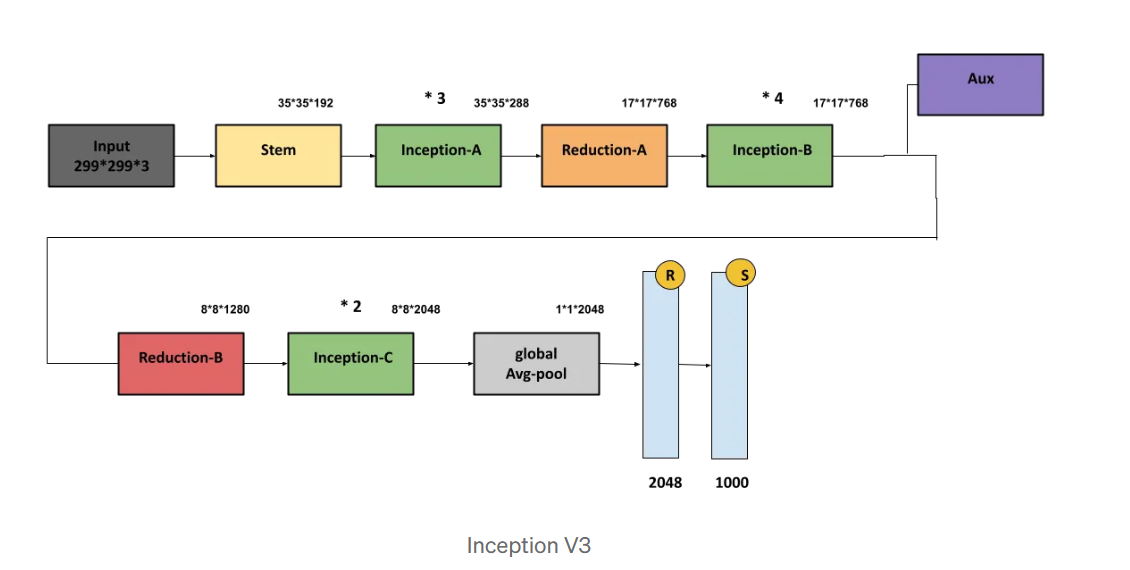

In [2]:
import torch.nn as nn
import torch
import torch.nn.functional as F



In [3]:
class ConvolutionBlock(nn.Module):
  def __init__(self , in_channels , out_channels , kernel_size , stride , padding):
    super(ConvolutionBlock , self).__init__()
    self.conv = nn.Conv2d(in_channels , out_channels , kernel_size , stride , padding)
    self.batchNormalization = nn.BatchNorm2d(out_channels)
    self.activation = nn.ReLU()
  
  def forward(self , x):
    out = self.conv(x)
    out = self.batchNormalization(out)
    out = self.activation(out)
    return out



In [4]:
class StemBlock(nn.Module):
  def __init__(self):
    super(StemBlock , self).__init__()
    self.conv1 = ConvolutionBlock(3,32,3,2,0)
    self.conv2 = ConvolutionBlock(32,32,3,1,0)
    self.conv3 = ConvolutionBlock(32,64,3,1,1)
    self.conv4 = ConvolutionBlock(64,80,3,1,0)
    self.conv5 = ConvolutionBlock(80,192,3,1,1)
    self.maxPool = nn.MaxPool2d(kernel_size=(3,3) , stride=(2,2))
  def forward(self , x):
   out = self.conv1(x)
   out = self.conv2(out)
   out = self.conv3(out)
   out = self.maxPool(out)
   out = self.conv4(out)
   out = self.conv5(out)
   out = self.maxPool(out)
   return out


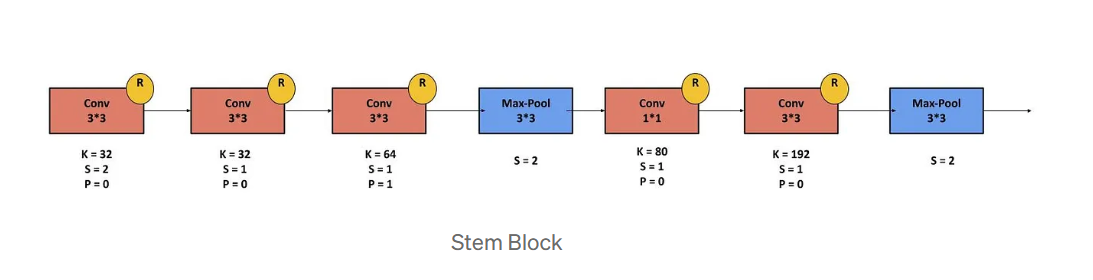

In [5]:

class InceptionBlock_A(nn.Module):
  def __init__(self , in_channels , nbr_kernels):
    super(InceptionBlock_A , self).__init__()

    self.branch1 = nn.Sequential(
        ConvolutionBlock(in_channels , 64 , 1 , 1 , 0),
        ConvolutionBlock(64 , 96 , 3 , 1 , 1),
        ConvolutionBlock(96 , 96 , 3 , 1 , 1)
    )

    self.branch2 = nn.Sequential(
        ConvolutionBlock(in_channels , 48 , 1 , 1 , 0),
        ConvolutionBlock(48 , 64 , 3 , 1 , 1)
    )

    self.branch3 = nn.Sequential(
        nn.AvgPool2d(kernel_size=(3,3) , stride=1 , padding=1),
        ConvolutionBlock(in_channels , 64 , 1 , 1 , 0)
    )
    self.branch4 = ConvolutionBlock(in_channels , 64 , 1 , 1 , 0)

  def forward(self , x):
    branch1 = self.branch1(x)
    branch2 = self.branch2(x)
    branch3 = self.branch3(x)
    branch4 = self.branch4(x)
    out = torch.cat([branch1 , branch2 , branch3 , branch4] , 1)   
    return out   


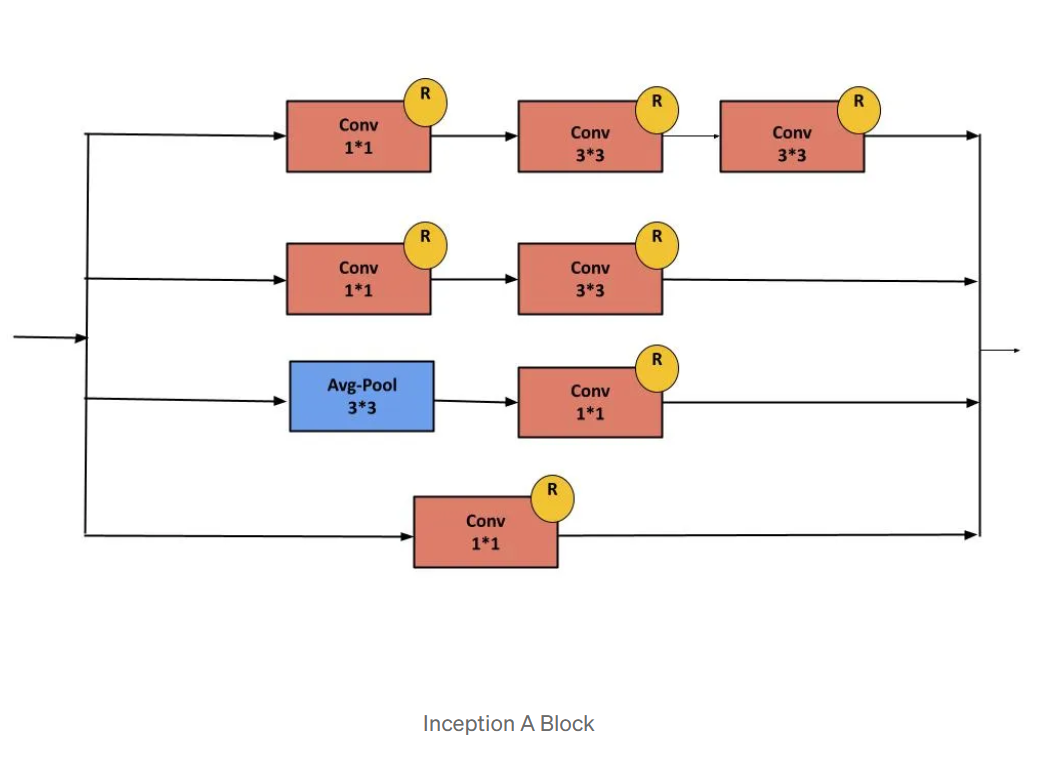

In [6]:

class InceptionBlock_B(nn.Module):
  def __init__(self , in_channels , nbr_kernels):
    super(InceptionBlock_B , self).__init__()

    self.branch1 = ConvolutionBlock(in_channels , 192 , 1 , 1 , 0)

    self.branch2 = nn.Sequential(
        ConvolutionBlock(in_channels , nbr_kernels , 1 , 1 , 0),
        ConvolutionBlock(nbr_kernels , nbr_kernels , (1,7) , 1 , (0,3)),
        ConvolutionBlock(nbr_kernels , 192 , (7,1) , 1 , (3,0))
    )

    self.branch3 = nn.Sequential(
        ConvolutionBlock(in_channels , nbr_kernels , 1 , 1 , 0),
        ConvolutionBlock(nbr_kernels , nbr_kernels , (7,1) , 1 , (0,3)),
        ConvolutionBlock(nbr_kernels , nbr_kernels , (1,7) , 1 , (3,0)),
        ConvolutionBlock(nbr_kernels , nbr_kernels , (7,1) , 1 , (0,3)),
        ConvolutionBlock(nbr_kernels , 192 , (1,7) , 1 , (3,0)),
    )

    self.branch4 = nn.Sequential(
        nn.AvgPool2d(kernel_size=(3,3) , stride=1 , padding=1),
        ConvolutionBlock(in_channels , 192 , 1 , 1 , 0)
    )

  def forward(self , x):

   branch1 = self.branch1(x)
   branch2 = self.branch2(x)
   branch3 = self.branch3(x)
   branch4 = self.branch4(x)   

   out = torch.cat([branch1 ,branch2 , branch3 ,branch4 ] , 1)

   return out


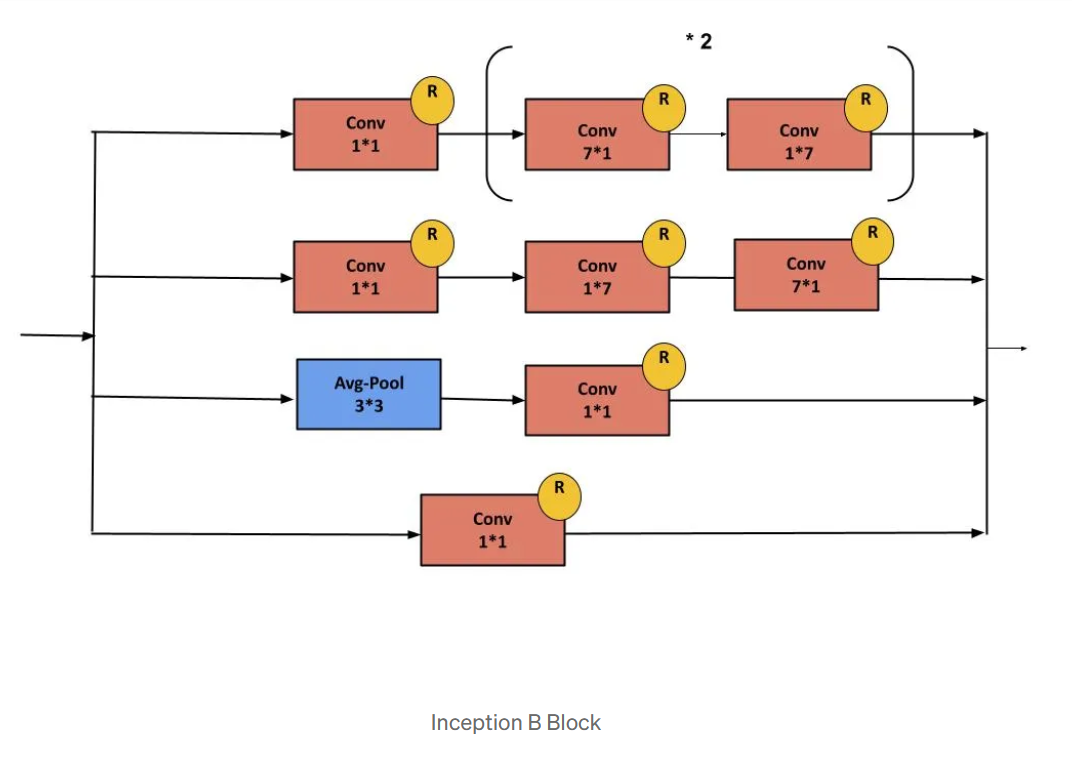

In [7]:

class InceptionBlock_C(nn.Module):
  def __init__(self , in_channels):
    super(InceptionBlock_C , self).__init__()

    self.branch1 = ConvolutionBlock(in_channels , 320 , 1 , 1 , 0)

    self.branch2 = nn.Sequential(
        nn.AvgPool2d(kernel_size=(3,3) , stride=1 , padding=1),
        ConvolutionBlock(in_channels , 192 , 1 , 1 , 0)
    )

    self.branch3 = ConvolutionBlock(in_channels , 384 , 1 , 1 , 0)

    self.branch3_1 = ConvolutionBlock(384 , 384 , (1,3) , 1 , (0,1))

    self.branch3_2 = ConvolutionBlock(384 , 384 , (3,1) , 1 , (1,0))    

    self.branch4 = nn.Sequential(
        ConvolutionBlock(in_channels , 448 , 1 , 1 , 0),
        ConvolutionBlock(448 , 384 , 3 , 1 , 1)
    )

    self.branch4_1 = ConvolutionBlock(384 , 384 , (1,3) , 1 , (0,1))
    self.branch4_2 = ConvolutionBlock(384 , 384 , (3,1) , 1 , (1,0))
 
  def forward(self , x):

   branch1 = self.branch1(x)

   branch2 = self.branch2(x)

   branch3 = self.branch3(x)
   
   branch3 = torch.cat([self.branch3_1(branch3) , self.branch3_2(branch3)] , 1)

   branch4 = self.branch4(x)

   branch4_1 = self.branch4_1(branch4)
   branch4_2 = self.branch4_2(branch4)

   branch4 = torch.cat([ branch4_1,branch4_2 ] , 1)
   
   out = torch.cat([branch1 , branch2 , branch3 , branch4] , 1)

   return out



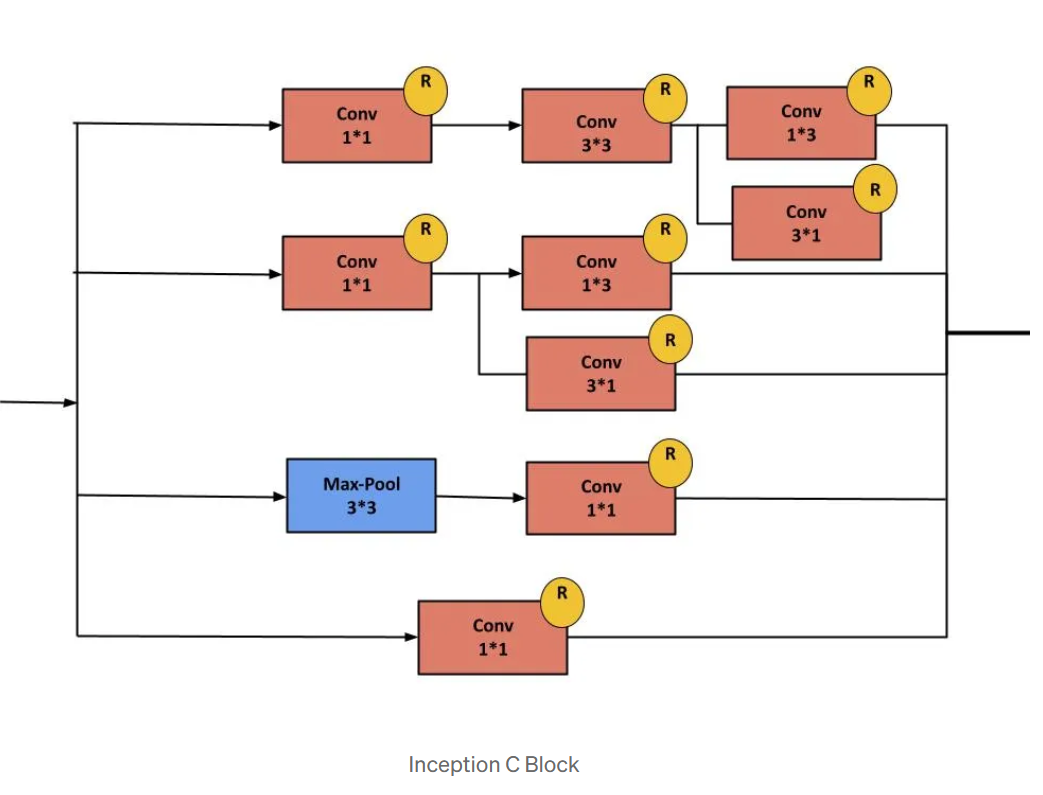

In [ ]:

class ReductionBlock_A(nn.Module):
  def __init__(self , in_channels):
    super(ReductionBlock_A , self).__init__()
    self.branch1 = nn.Sequential(
        ConvolutionBlock(in_channels , 64 , 1 , 1 , 0),
        ConvolutionBlock(64 , 96 , 3 , 1 , 1),
        ConvolutionBlock(96 , 96 , 3 , 2 , 0)
    )
    self.branch2 = ConvolutionBlock(in_channels , 384 , 3 , 2 , 0)
    self.branch3 = nn.MaxPool2d(kernel_size=(3,3) , stride=2 , padding=0)
  def forward(self , x):
   branch1 = self.branch1(x)
   branch2 = self.branch2(x)
   branch3 = self.branch3(x)
   out = torch.cat([branch1 , branch2 , branch3] , 1)
   return out


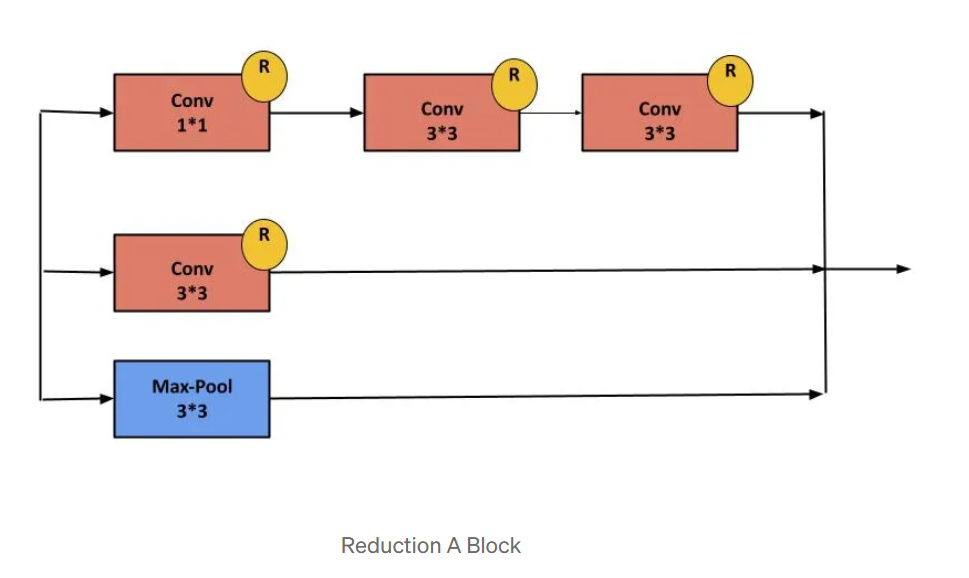

In [ ]:

class ReductionBlock_B(nn.Module):
  def __init__(self , in_channels):
    super(ReductionBlock_B , self).__init__()
    self.branch1 = nn.Sequential(
        ConvolutionBlock(in_channels , 192 , 1 , 1 , 0),
        ConvolutionBlock(192 , 192 , (1,7) , 1 , (0,3)),
        ConvolutionBlock(192 , 192 , (7,1) , 1 , (3,0)),
        ConvolutionBlock(192 , 192 , 3 , 2 , 0)
    )   
    self.branch2 = nn.Sequential(
        ConvolutionBlock(in_channels , 192 , 1 , 1 , 0),
        ConvolutionBlock(192 , 320 , 3 , 2 , 0)
    )
    self.branch3 = nn.MaxPool2d(kernel_size=(3,3) , stride=2 )
  def forward(self , x):
    branch1 = self.branch1(x)
    branch2 = self.branch2(x)
    branch3 = self.branch3(x)
    out = torch.cat([branch1 , branch2 , branch3] , 1)
    return out


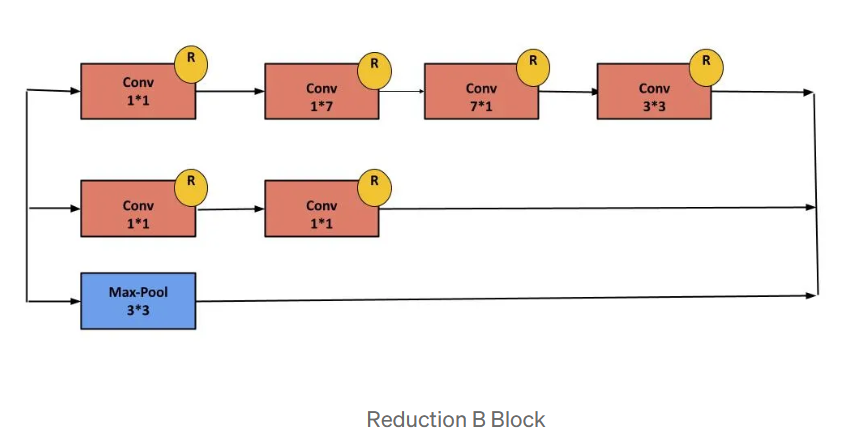

In [ ]:

class Aux_Block(nn.Module):
  
  def __init__(self , in_channels):
    super(Aux_Block , self).__init__()
    self.avgPool = nn.AvgPool2d(kernel_size=(5,5) , stride=3 , padding=0)
    self.conv1 = ConvolutionBlock(in_channels , 128 , 1 , 1 , 0)
    self.conv2 = ConvolutionBlock(128 , 768 , 5 , 1 , 0)
    self.fc1 = nn.Linear(in_features= 768 , out_features= 1024)
    self.fc2 = nn.Linear(in_features= 1024 , out_features= 4)
  def forward(self , x):
    out = self.avgPool(x)
    out = self.conv1(out)
    out = self.conv2(out)
    out = torch.flatten(out , 1)
    out = self.fc1(out)
    out = nn.ReLU()(out)
    out = self.fc2(out)
    out = nn.Softmax()(out)
    return out

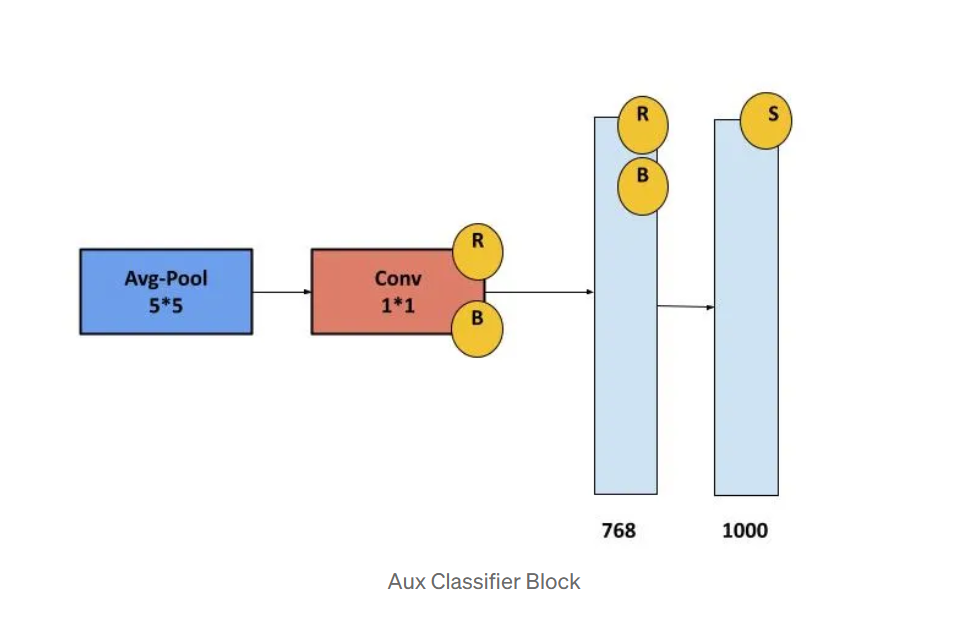

In [ ]:

class InceptionV3(nn.Module):
  def __init__(self):
    super(InceptionV3 , self).__init__()
    self.stem = StemBlock()
    self.inceptionA_1 = InceptionBlock_A(192 , 32)
    self.inceptionA_2 = InceptionBlock_A(288 , 64)
    self.inceptionA_3 = InceptionBlock_A(288 , 64)
    self.reductionA = ReductionBlock_A(288)
    self.inceptionB_1 = InceptionBlock_B(768 , 128)
    self.inceptionB_2 = InceptionBlock_B(768 , 160)
    self.inceptionB_3 = InceptionBlock_B(768 , 160)
    self.inceptionB_4 = InceptionBlock_B(768 , 192)
    self.aux = Aux_Block(768)
    self.reductionB = ReductionBlock_B(768)
    self.inceptionC_1 = InceptionBlock_C(1280)
    self.inceptionC_2 = InceptionBlock_C(2048)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc1 = nn.Linear(in_features=2048 ,out_features= 2048)
    self.fc2 = nn.Linear(in_features=2048 , out_features= 4)
  def forward(self , x):
    out = self.stem(x)
    out = self.inceptionA_1(out)
    out = self.inceptionA_2(out)
    out = self.inceptionA_3(out)
    out = self.reductionA(out)
    out = self.inceptionB_1(out)
    out = self.inceptionB_2(out)
    out = self.inceptionB_3(out)
    out = self.inceptionB_4(out)
    aux = self.aux(out)
    out = self.reductionB(out)
    out = self.inceptionC_1(out)
    out = self.inceptionC_2(out)
    out = self.avgpool(out)
    out = out.reshape(out.shape[0] , -1)
    out = self.fc1(out)
    out = nn.ReLU()(out)
    out = self.fc2(out)
    out = nn.Softmax()(out)
    return out , aux 

In [ ]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = InceptionV3()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_model(model, train_loader, valid_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # FIXED
        
        train_acc = 100 * correct / total
        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        
        evaluate_model(model, valid_loader, name="Validation")

def evaluate_model(model, loader, name="Test"):
    model.eval()
    correct, total = 0, 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())  # FIXED

            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # FIXED
    acc = 100 * correct / total
    print(f"{name} Accuracy: {acc:.2f}%")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
    disp.plot(cmap='viridis')


  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:21<00:00,  2.99it/s]


Epoch 1, Loss: 87.7761, Train Accuracy: 28.90%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 19.44%
              precision    recall  f1-score   support

       Angry       0.22      0.44      0.30         9
       Other       0.17      0.50      0.25         6
         Sad       0.00      0.00      0.00        10
       happy       0.00      0.00      0.00        11

    accuracy                           0.19        36
   macro avg       0.10      0.24      0.14        36
weighted avg       0.08      0.19      0.12        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.90it/s]


Epoch 2, Loss: 86.9145, Train Accuracy: 31.90%
Validation Accuracy: 22.22%
              precision    recall  f1-score   support

       Angry       0.19      0.33      0.24         9
       Other       0.09      0.17      0.12         6
         Sad       0.00      0.00      0.00        10
       happy       0.50      0.36      0.42        11

    accuracy                           0.22        36
   macro avg       0.19      0.22      0.19        36
weighted avg       0.21      0.22      0.21        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.90it/s]


Epoch 3, Loss: 85.9229, Train Accuracy: 32.60%
Validation Accuracy: 19.44%
              precision    recall  f1-score   support

       Angry       0.29      0.56      0.38         9
       Other       0.07      0.17      0.10         6
         Sad       0.00      0.00      0.00        10
       happy       0.50      0.09      0.15        11

    accuracy                           0.19        36
   macro avg       0.22      0.20      0.16        36
weighted avg       0.24      0.19      0.16        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.89it/s]


Epoch 4, Loss: 85.1593, Train Accuracy: 33.10%
Validation Accuracy: 30.56%
              precision    recall  f1-score   support

       Angry       0.30      0.33      0.32         9
       Other       0.00      0.00      0.00         6
         Sad       0.25      0.30      0.27        10
       happy       0.56      0.45      0.50        11

    accuracy                           0.31        36
   macro avg       0.28      0.27      0.27        36
weighted avg       0.31      0.31      0.31        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.92it/s]


Epoch 5, Loss: 85.1721, Train Accuracy: 33.50%
Validation Accuracy: 27.78%
              precision    recall  f1-score   support

       Angry       0.27      0.33      0.30         9
       Other       0.20      0.33      0.25         6
         Sad       0.00      0.00      0.00        10
       happy       0.45      0.45      0.45        11

    accuracy                           0.28        36
   macro avg       0.23      0.28      0.25        36
weighted avg       0.24      0.28      0.26        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:15<00:00,  3.94it/s]


Epoch 6, Loss: 86.4211, Train Accuracy: 31.30%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 22.22%
              precision    recall  f1-score   support

       Angry       0.24      0.44      0.31         9
       Other       0.22      0.33      0.27         6
         Sad       0.20      0.20      0.20        10
       happy       0.00      0.00      0.00        11

    accuracy                           0.22        36
   macro avg       0.16      0.24      0.19        36
weighted avg       0.15      0.22      0.18        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.80it/s]


Epoch 7, Loss: 85.4811, Train Accuracy: 32.90%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 22.22%
              precision    recall  f1-score   support

       Angry       0.25      0.33      0.29         9
       Other       0.09      0.17      0.12         6
         Sad       0.31      0.40      0.35        10
       happy       0.00      0.00      0.00        11

    accuracy                           0.22        36
   macro avg       0.16      0.23      0.19        36
weighted avg       0.16      0.22      0.19        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.92it/s]


Epoch 8, Loss: 85.5034, Train Accuracy: 33.20%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 27.78%
              precision    recall  f1-score   support

       Angry       0.38      0.33      0.35         9
       Other       0.08      0.17      0.11         6
         Sad       0.00      0.00      0.00        10
       happy       0.38      0.55      0.44        11

    accuracy                           0.28        36
   macro avg       0.21      0.26      0.23        36
weighted avg       0.22      0.28      0.24        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.90it/s]


Epoch 9, Loss: 84.2591, Train Accuracy: 38.10%
Validation Accuracy: 19.44%
              precision    recall  f1-score   support

       Angry       0.28      0.56      0.37         9
       Other       0.00      0.00      0.00         6
         Sad       0.00      0.00      0.00        10
       happy       0.29      0.18      0.22        11

    accuracy                           0.19        36
   macro avg       0.14      0.18      0.15        36
weighted avg       0.16      0.19      0.16        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.93it/s]


Epoch 10, Loss: 83.6569, Train Accuracy: 36.70%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 38.89%
              precision    recall  f1-score   support

       Angry       0.30      0.33      0.32         9
       Other       0.20      0.33      0.25         6
         Sad       0.00      0.00      0.00        10
       happy       0.56      0.82      0.67        11

    accuracy                           0.39        36
   macro avg       0.27      0.37      0.31        36
weighted avg       0.28      0.39      0.32        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.92it/s]


Epoch 11, Loss: 84.0696, Train Accuracy: 36.90%
Validation Accuracy: 25.00%
              precision    recall  f1-score   support

       Angry       0.23      0.56      0.32         9
       Other       0.00      0.00      0.00         6
         Sad       0.25      0.20      0.22        10
       happy       0.67      0.18      0.29        11

    accuracy                           0.25        36
   macro avg       0.29      0.23      0.21        36
weighted avg       0.33      0.25      0.23        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.91it/s]


Epoch 12, Loss: 83.2486, Train Accuracy: 39.50%
Validation Accuracy: 27.78%
              precision    recall  f1-score   support

       Angry       0.60      0.33      0.43         9
       Other       0.07      0.17      0.10         6
         Sad       0.00      0.00      0.00        10
       happy       0.50      0.55      0.52        11

    accuracy                           0.28        36
   macro avg       0.29      0.26      0.26        36
weighted avg       0.31      0.28      0.28        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.91it/s]


Epoch 13, Loss: 82.0310, Train Accuracy: 39.90%
Validation Accuracy: 33.33%
              precision    recall  f1-score   support

       Angry       0.27      0.33      0.30         9
       Other       0.14      0.17      0.15         6
         Sad       0.25      0.20      0.22        10
       happy       0.60      0.55      0.57        11

    accuracy                           0.33        36
   macro avg       0.32      0.31      0.31        36
weighted avg       0.34      0.33      0.34        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.91it/s]


Epoch 14, Loss: 82.9868, Train Accuracy: 38.60%
Validation Accuracy: 33.33%
              precision    recall  f1-score   support

       Angry       0.20      0.11      0.14         9
       Other       0.11      0.17      0.13         6
         Sad       0.50      0.20      0.29        10
       happy       0.44      0.73      0.55        11

    accuracy                           0.33        36
   macro avg       0.31      0.30      0.28        36
weighted avg       0.34      0.33      0.31        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.89it/s]


Epoch 15, Loss: 84.4716, Train Accuracy: 36.50%
Validation Accuracy: 25.00%
              precision    recall  f1-score   support

       Angry       0.24      0.44      0.31         9
       Other       0.17      0.17      0.17         6
         Sad       0.12      0.10      0.11        10
       happy       0.60      0.27      0.37        11

    accuracy                           0.25        36
   macro avg       0.28      0.25      0.24        36
weighted avg       0.30      0.25      0.25        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.92it/s]


Epoch 16, Loss: 82.4843, Train Accuracy: 41.00%
Validation Accuracy: 25.00%
              precision    recall  f1-score   support

       Angry       0.12      0.11      0.12         9
       Other       0.25      0.33      0.29         6
         Sad       0.00      0.00      0.00        10
       happy       0.43      0.55      0.48        11

    accuracy                           0.25        36
   macro avg       0.20      0.25      0.22        36
weighted avg       0.20      0.25      0.22        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.91it/s]


Epoch 17, Loss: 82.2153, Train Accuracy: 40.60%
Validation Accuracy: 30.56%
              precision    recall  f1-score   support

       Angry       0.33      0.44      0.38         9
       Other       0.00      0.00      0.00         6
         Sad       0.00      0.00      0.00        10
       happy       0.50      0.64      0.56        11

    accuracy                           0.31        36
   macro avg       0.21      0.27      0.24        36
weighted avg       0.24      0.31      0.27        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.93it/s]


Epoch 18, Loss: 80.7285, Train Accuracy: 44.30%
Validation Accuracy: 30.56%
              precision    recall  f1-score   support

       Angry       0.27      0.44      0.33         9
       Other       0.20      0.17      0.18         6
         Sad       0.00      0.00      0.00        10
       happy       0.50      0.55      0.52        11

    accuracy                           0.31        36
   macro avg       0.24      0.29      0.26        36
weighted avg       0.25      0.31      0.27        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.92it/s]


Epoch 19, Loss: 79.0652, Train Accuracy: 48.00%
Validation Accuracy: 33.33%
              precision    recall  f1-score   support

       Angry       0.43      0.33      0.38         9
       Other       0.12      0.17      0.14         6
         Sad       0.25      0.10      0.14        10
       happy       0.41      0.64      0.50        11

    accuracy                           0.33        36
   macro avg       0.30      0.31      0.29        36
weighted avg       0.32      0.33      0.31        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.93it/s]


Epoch 20, Loss: 79.5048, Train Accuracy: 44.00%
Validation Accuracy: 36.11%
              precision    recall  f1-score   support

       Angry       0.75      0.33      0.46         9
       Other       0.14      0.17      0.15         6
         Sad       0.25      0.20      0.22        10
       happy       0.41      0.64      0.50        11

    accuracy                           0.36        36
   macro avg       0.39      0.33      0.33        36
weighted avg       0.41      0.36      0.36        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.93it/s]


Epoch 21, Loss: 78.9501, Train Accuracy: 47.60%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Validation Accuracy: 30.56%
              precision    recall  f1-score   support

       Angry       0.31      0.44      0.36         9
       Other       0.17      0.33      0.22         6
         Sad       0.00      0.00      0.00        10
       happy       0.62      0.45      0.53        11

    accuracy                           0.31        36
   macro avg       0.27      0.31      0.28        36
weighted avg       0.30      0.31      0.29        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:15<00:00,  3.96it/s]


Epoch 22, Loss: 80.9250, Train Accuracy: 44.30%
Validation Accuracy: 30.56%
              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00         9
       Other       0.20      0.17      0.18         6
         Sad       0.20      0.20      0.20        10
       happy       0.50      0.73      0.59        11

    accuracy                           0.31        36
   macro avg       0.23      0.27      0.24        36
weighted avg       0.24      0.31      0.27        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.93it/s]


Epoch 23, Loss: 79.5559, Train Accuracy: 47.40%
Validation Accuracy: 30.56%
              precision    recall  f1-score   support

       Angry       0.27      0.44      0.33         9
       Other       0.17      0.33      0.22         6
         Sad       0.00      0.00      0.00        10
       happy       0.71      0.45      0.56        11

    accuracy                           0.31        36
   macro avg       0.29      0.31      0.28        36
weighted avg       0.31      0.31      0.29        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.90it/s]


Epoch 24, Loss: 80.0645, Train Accuracy: 45.30%
Validation Accuracy: 30.56%
              precision    recall  f1-score   support

       Angry       0.27      0.44      0.33         9
       Other       0.00      0.00      0.00         6
         Sad       0.00      0.00      0.00        10
       happy       0.70      0.64      0.67        11

    accuracy                           0.31        36
   macro avg       0.24      0.27      0.25        36
weighted avg       0.28      0.31      0.29        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.91it/s]


Epoch 25, Loss: 78.5238, Train Accuracy: 48.10%
Validation Accuracy: 27.78%
              precision    recall  f1-score   support

       Angry       0.40      0.44      0.42         9
       Other       0.10      0.17      0.12         6
         Sad       0.11      0.10      0.11        10
       happy       0.57      0.36      0.44        11

    accuracy                           0.28        36
   macro avg       0.30      0.27      0.27        36
weighted avg       0.32      0.28      0.29        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.93it/s]


Epoch 26, Loss: 76.8088, Train Accuracy: 51.90%
Validation Accuracy: 36.11%
              precision    recall  f1-score   support

       Angry       0.33      0.56      0.42         9
       Other       0.50      0.17      0.25         6
         Sad       0.00      0.00      0.00        10
       happy       0.44      0.64      0.52        11

    accuracy                           0.36        36
   macro avg       0.32      0.34      0.30        36
weighted avg       0.30      0.36      0.30        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.88it/s]


Epoch 27, Loss: 77.5567, Train Accuracy: 49.70%
Validation Accuracy: 30.56%
              precision    recall  f1-score   support

       Angry       0.25      0.22      0.24         9
       Other       0.00      0.00      0.00         6
         Sad       0.17      0.10      0.12        10
       happy       0.40      0.73      0.52        11

    accuracy                           0.31        36
   macro avg       0.20      0.26      0.22        36
weighted avg       0.23      0.31      0.25        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.91it/s]


Epoch 28, Loss: 77.3284, Train Accuracy: 49.40%
Validation Accuracy: 27.78%
              precision    recall  f1-score   support

       Angry       0.25      0.33      0.29         9
       Other       0.25      0.17      0.20         6
         Sad       0.00      0.00      0.00        10
       happy       0.46      0.55      0.50        11

    accuracy                           0.28        36
   macro avg       0.24      0.26      0.25        36
weighted avg       0.25      0.28      0.26        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.93it/s]


Epoch 29, Loss: 78.6356, Train Accuracy: 48.30%
Validation Accuracy: 36.11%
              precision    recall  f1-score   support

       Angry       0.31      0.44      0.36         9
       Other       0.29      0.33      0.31         6
         Sad       0.00      0.00      0.00        10
       happy       0.78      0.64      0.70        11

    accuracy                           0.36        36
   macro avg       0.34      0.35      0.34        36
weighted avg       0.36      0.36      0.36        36



  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 63/63 [00:16<00:00,  3.92it/s]


Epoch 30, Loss: 77.0803, Train Accuracy: 51.40%
Validation Accuracy: 36.11%
              precision    recall  f1-score   support

       Angry       0.40      0.44      0.42         9
       Other       0.00      0.00      0.00         6
         Sad       0.17      0.10      0.12        10
       happy       0.53      0.73      0.62        11

    accuracy                           0.36        36
   macro avg       0.28      0.32      0.29        36
weighted avg       0.31      0.36      0.33        36



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Test Accuracy: 39.47%
              precision    recall  f1-score   support

       Angry       0.50      0.50      0.50        10
       Other       0.14      0.17      0.15         6
         Sad       0.30      0.27      0.29        11
       happy       0.55      0.55      0.55        11

    accuracy                           0.39        38
   macro avg       0.37      0.37      0.37        38
weighted avg       0.40      0.39      0.40        38



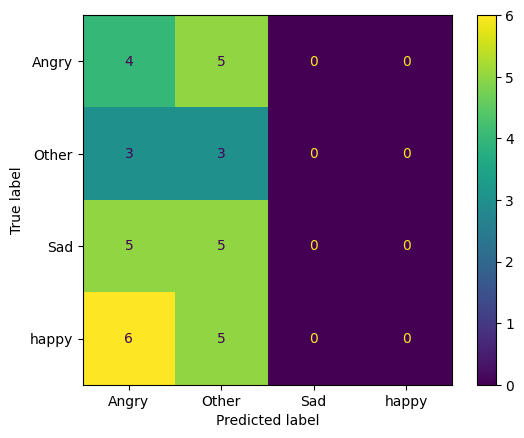

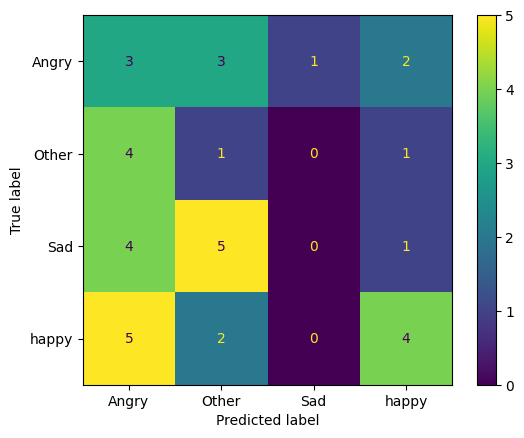

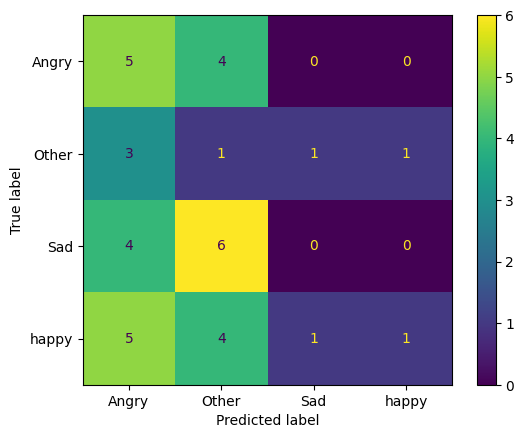

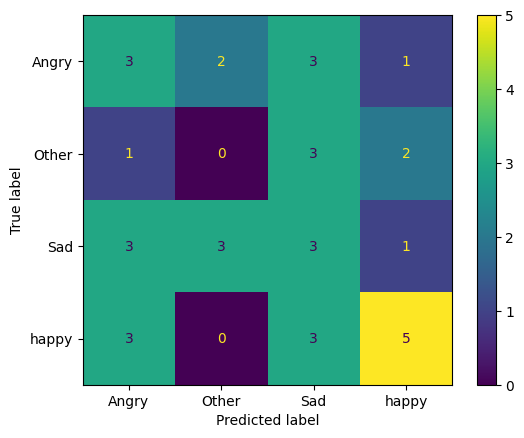

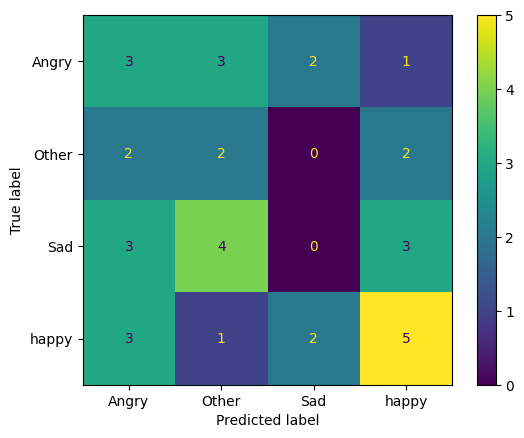

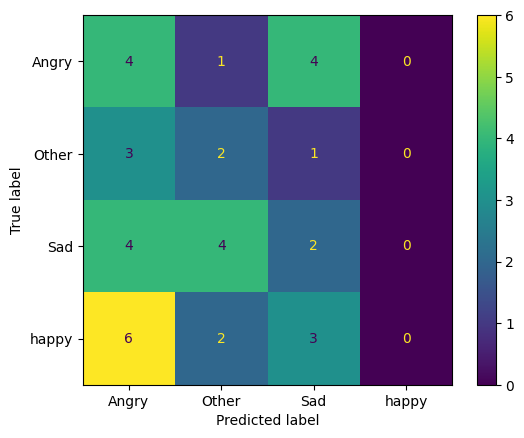

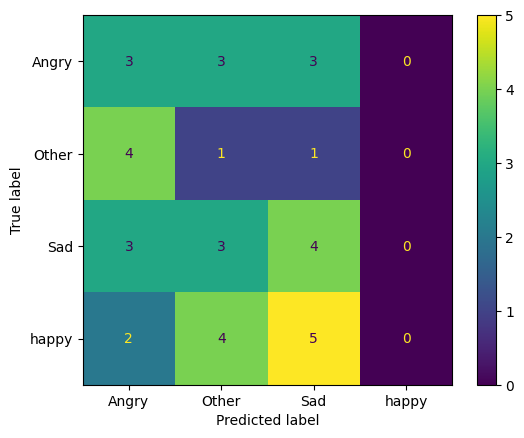

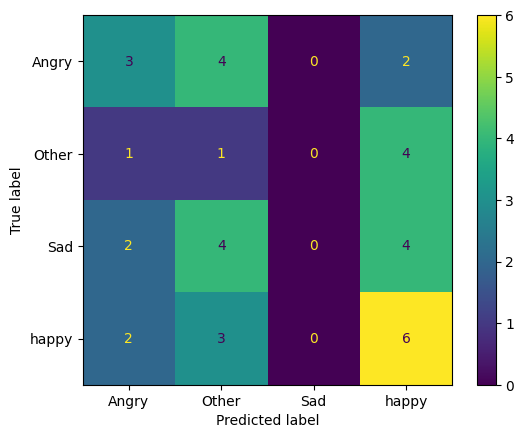

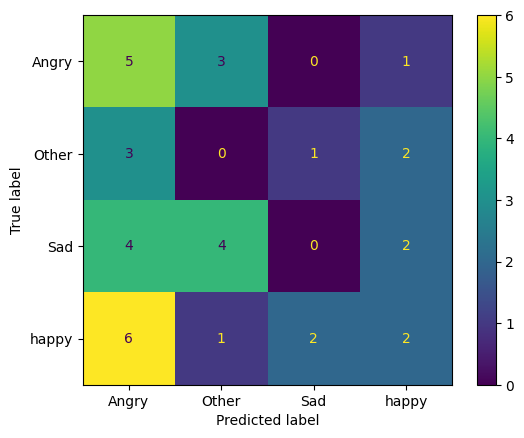

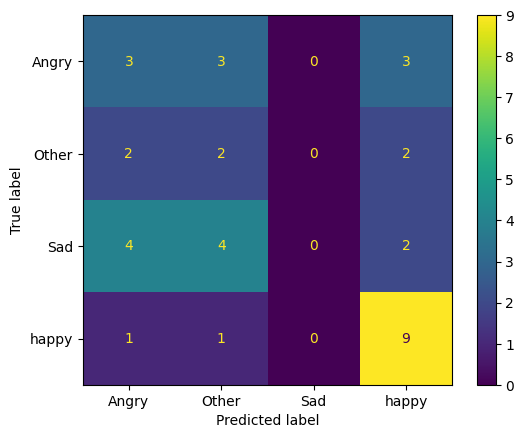

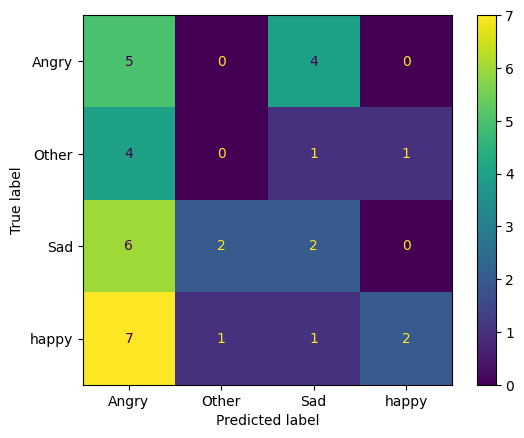

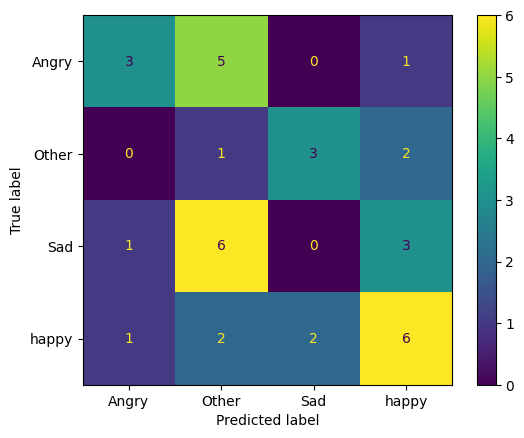

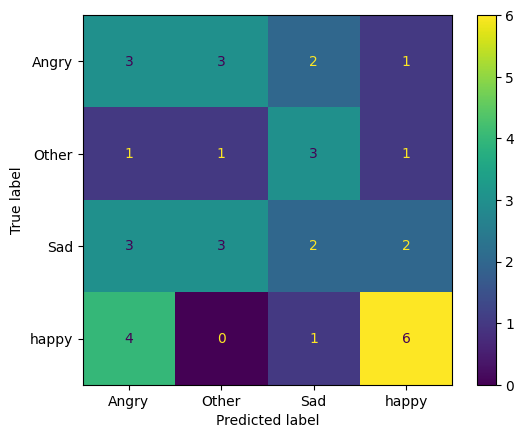

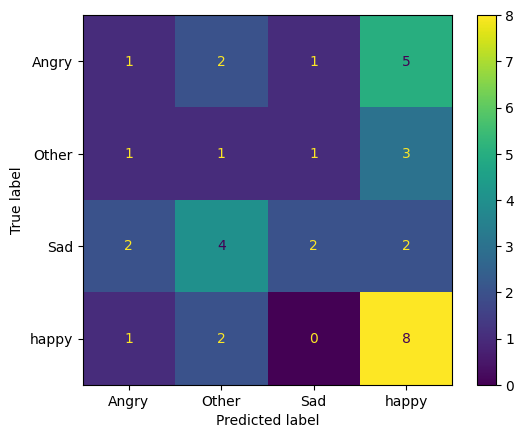

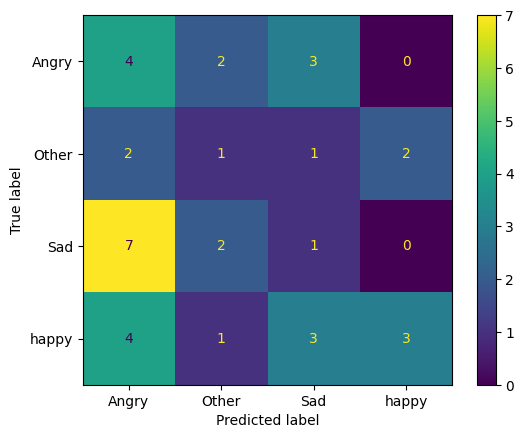

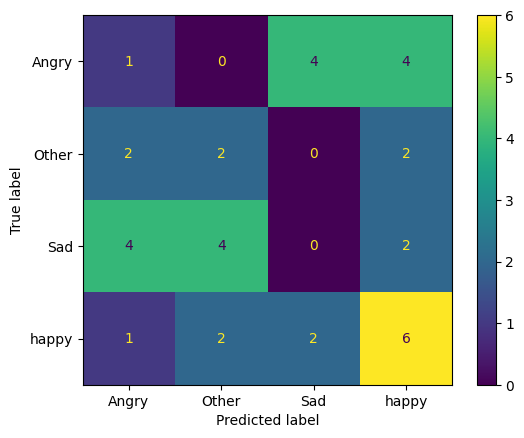

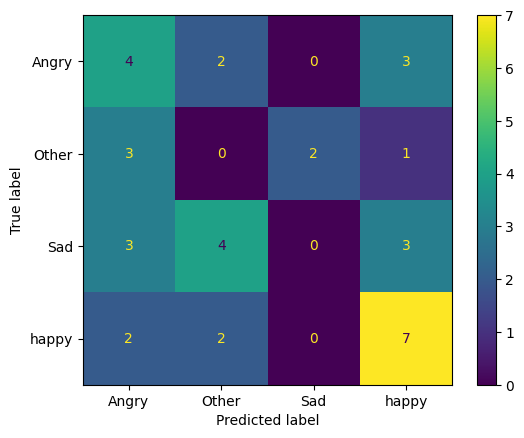

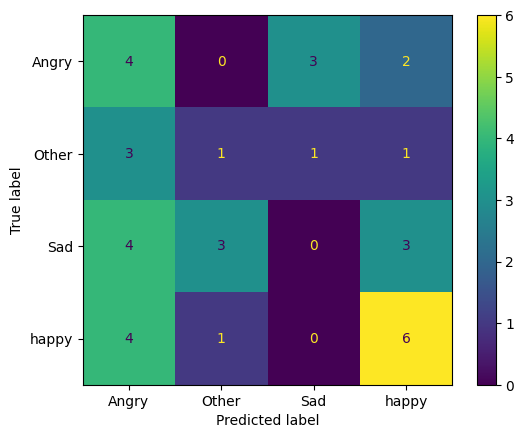

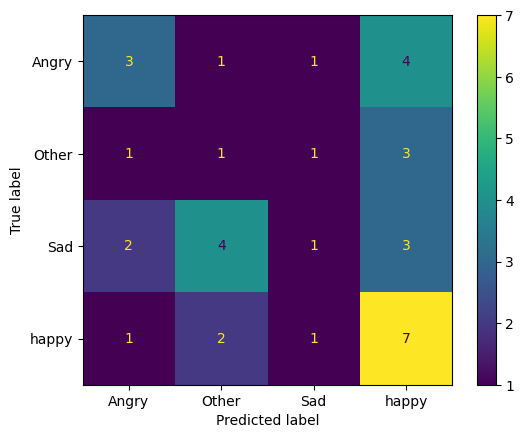

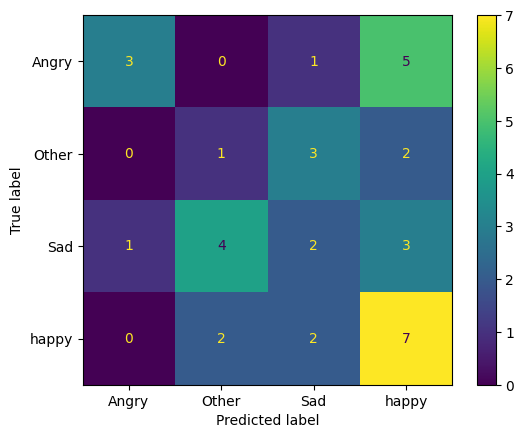

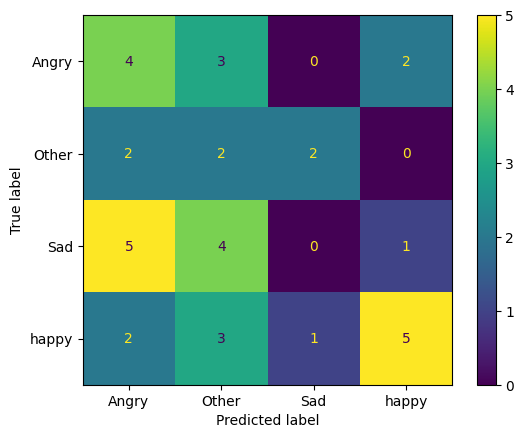

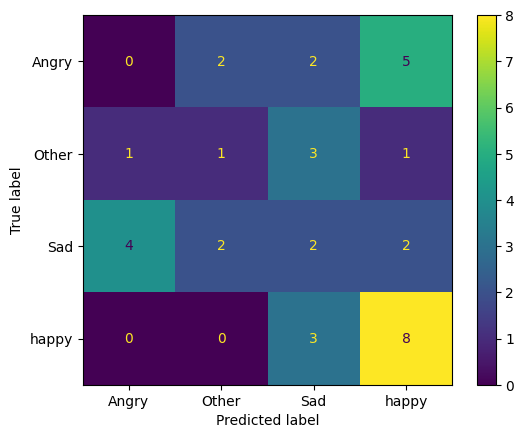

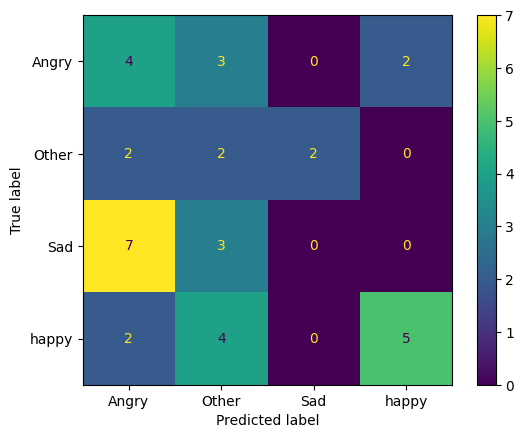

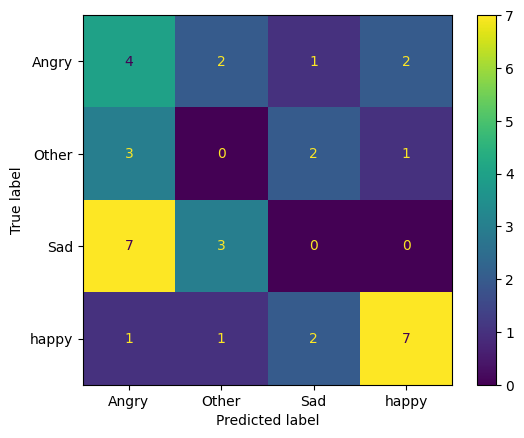

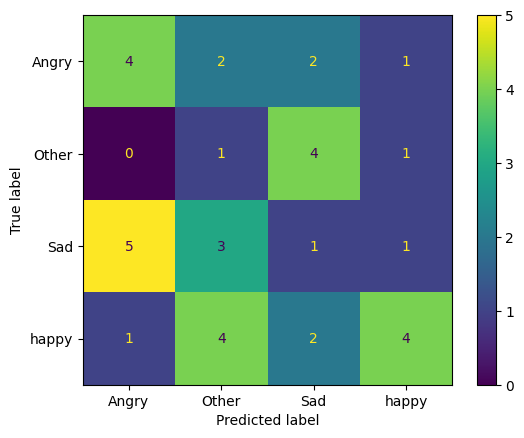

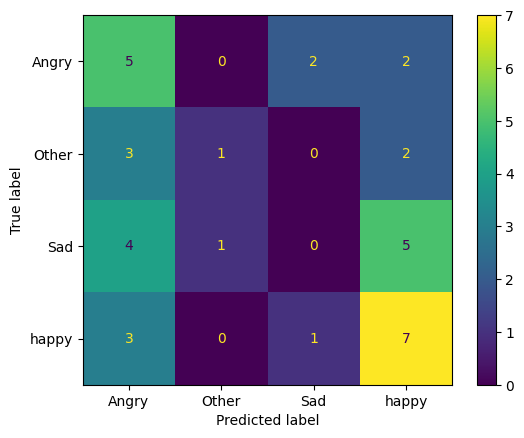

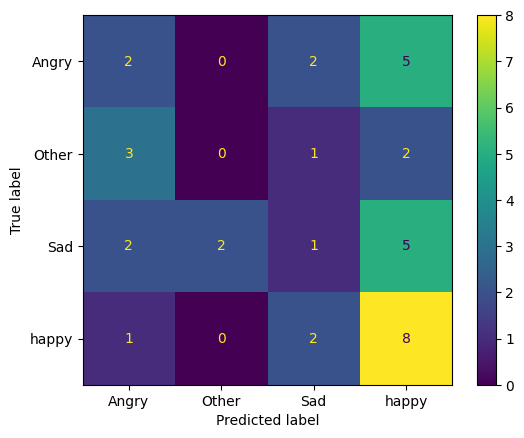

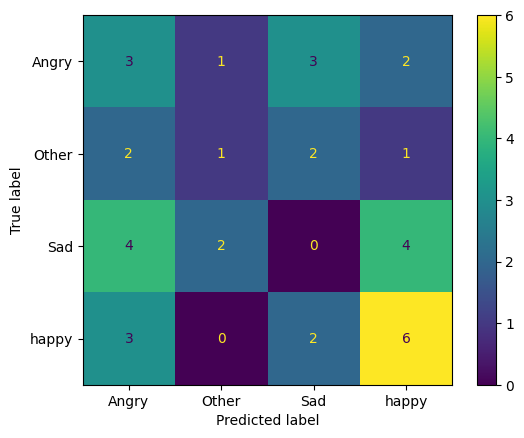

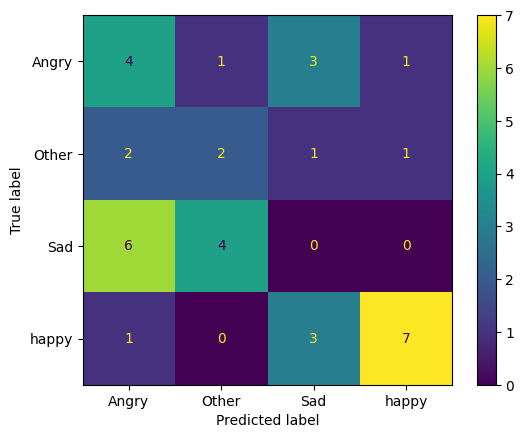

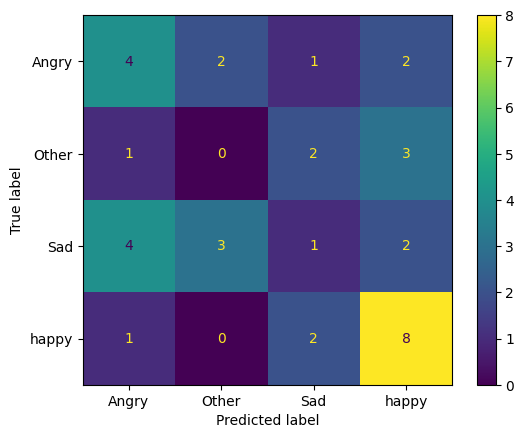

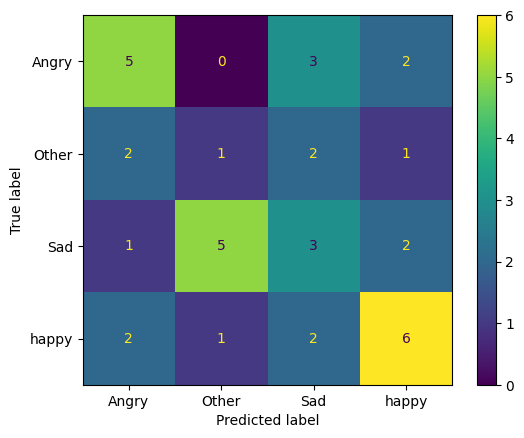

In [ ]:
train_model(model, train_loader, valid_loader, epochs=30)
evaluate_model(model, test_loader, name="Test")